# Analyze coefficients of `demographics_only_with_interactions` metamodel

In [1]:
from malid import config
from malid.trained_model_wrappers import BlendingMetamodel
from malid.datamodels import (
    GeneLocus,
    TargetObsColumnEnum,
)

In [2]:
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import genetools

In [5]:
base_model_train_fold_name = "train_smaller"
metamodel_fold_label_train = "validation"
gene_locus = GeneLocus.BCR | GeneLocus.TCR
classification_target = TargetObsColumnEnum.disease_all_demographics_present
# metamodel_flavor = "demographics_only"
metamodel_flavor = "demographics_only_with_interactions"
# metamodel_name = "ridge_cv"

In [6]:
fold_id = -1

/users/maximz/code/boyd-immune-repertoire-classification/out/in_house_peak_disease_timepoints/esm2_cdr3/blending_metamodel/BCR_TCR/disease_all_demographics_present/demographics_only_with_interactions/train_smaller_applied_to_validation_model.coefficients_global_fold.ridge_cv.png
/users/maximz/code/boyd-immune-repertoire-classification/out/in_house_peak_disease_timepoints/esm2_cdr3/blending_metamodel/BCR_TCR/disease_all_demographics_present/demographics_only_with_interactions/train_smaller_applied_to_validation_model.coefficients_global_fold.lasso_cv.png
/users/maximz/code/boyd-immune-repertoire-classification/out/in_house_peak_disease_timepoints/esm2_cdr3/blending_metamodel/BCR_TCR/disease_all_demographics_present/demographics_only_with_interactions/train_smaller_applied_to_validation_model.coefficients_global_fold.logisticregression_unregularized.png


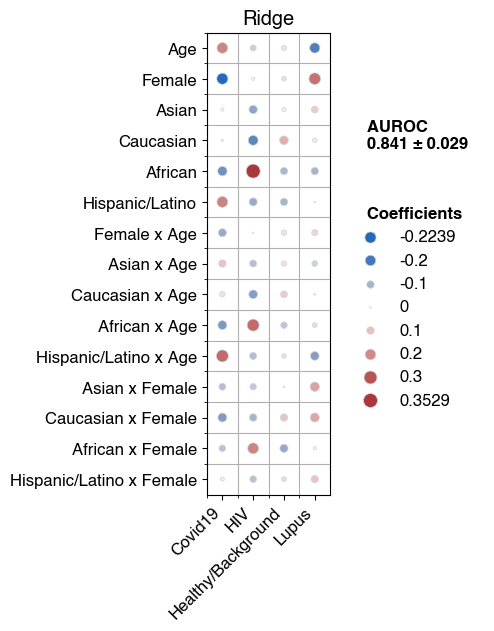

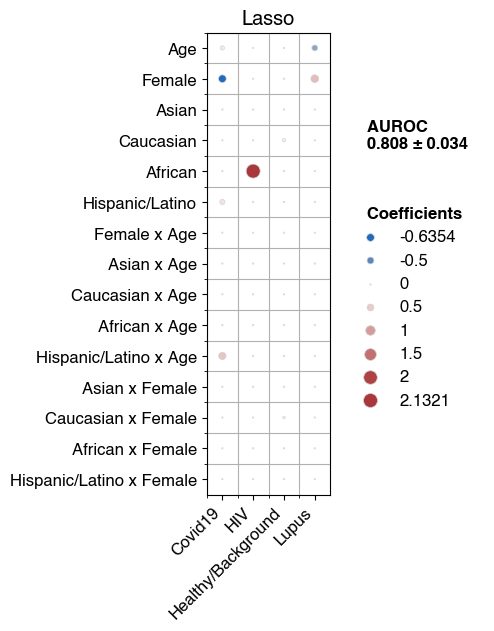

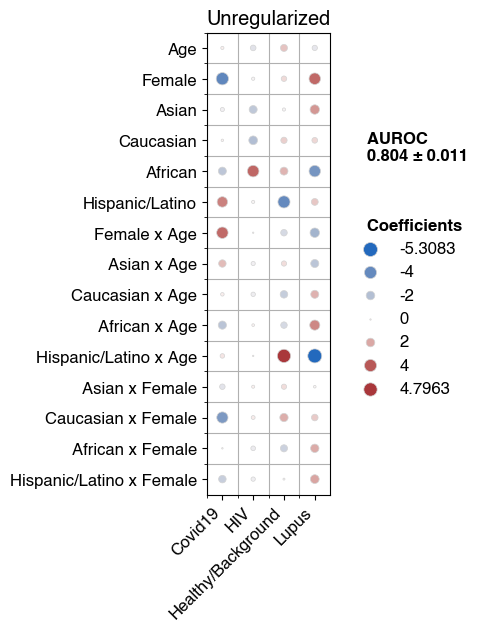

In [37]:
for metamodel_name, friendly_name in [
    ("ridge_cv", "Ridge"),
    ("lasso_cv", "Lasso"),
    ("logisticregression_unregularized", "Unregularized"),
]:
    clf = BlendingMetamodel.from_disk(
        fold_id=fold_id,
        metamodel_name=metamodel_name,
        base_model_train_fold_name=base_model_train_fold_name,
        metamodel_fold_label_train=metamodel_fold_label_train,
        gene_locus=gene_locus,
        target_obs_column=classification_target,
        metamodel_flavor=metamodel_flavor,
    )
    df_coefs = pd.DataFrame(
        clf.steps[-1][1].coef_,
        index=clf.steps[-1][1].classes_,
        columns=clf.steps[-1][1].feature_names_in_,
    ).T
    # sns.heatmap(df_coefs, center=0)
    df_coefs_melt = (
        df_coefs.melt(ignore_index=False, var_name="class", value_name="coef")
        .rename_axis(index="feature")
        .reset_index()
    )

    def convert_to_friendly_name(s):
        if s.startswith("interaction|"):
            parts = s.split("|")
            parts = [
                convert_to_friendly_name(parts[1]),
                convert_to_friendly_name(parts[2]),
            ]
            return " x ".join(parts)  # return "(" + ", ".join(parts) + ")"

        if s.startswith("demographics:"):
            s = s.replace("demographics:", "")

        s = s.replace("age", "Age")
        s = s.replace("sex_F", "Female")
        s = s.replace("ethnicity_condensed_", "")

        return s

    df_coefs_melt["feature_friendly"] = df_coefs_melt["feature"].apply(
        convert_to_friendly_name
    )
    df_coefs_melt[["feature", "feature_friendly"]].drop_duplicates()

    # Show the cross validated AUC on the plot:
    # 1) Load result table
    auc_string = pd.read_csv(
        clf.output_base_dir
        / f"{clf.model_file_prefix}.compare_model_scores.test_set_performance.tsv",
        sep="\t",
        index_col=0,
    ).loc[clf.metamodel_name]["ROC-AUC (weighted OvO) per fold"]
    # 2) Convert '0.804 +/- 0.011 (in 3 folds)' to '0.804 +/- 0.011'
    auc_string = auc_string.split(" (")[0]
    # 3) Convert '+/-' to '±' symbol
    auc_string = auc_string.replace("+/-", "±")

    # Make plot
    fig, ax = genetools.plots.plot_color_and_size_dotplot(
        data=df_coefs_melt,
        x_axis_key="class",
        y_axis_key="feature_friendly",
        value_key="coef",
        # color_cmap=sns.color_palette("magma_r", as_cmap=True),
        # color_cmap=sns.cm.rocket_r,
        color_cmap=sns.color_palette("vlag", as_cmap=True),
        color_and_size_vcenter=0,
        legend_text=f"AUROC\n{auc_string}\n\n\n\nCoefficients",
    )
    plt.xticks(rotation=45, ha="right")  # Adjust rotation from 90 to 45

    # plt.title(f"Fold {fold_id}")
    plt.title(friendly_name)  # metamodel_name

    fname_out = (
        clf.output_base_dir
        / f"{clf.model_file_prefix}.coefficients_global_fold.{clf.metamodel_name}.png"
    )
    genetools.plots.savefig(fig, fname_out, dpi=300)
    print(fname_out)

Note that the AUROC is over three cross validation folds (`fold_id` 0, 1, 2), while the coefficients are from the global fold (`fold_id` -1)